# Natural Language Processing with Amazon Reviews

Developed for the second project of the Artificial Intelligence course

## Setup and Environment

After installing Python 3 and the necessary packages, run the following code to import them:

In [6]:
%matplotlib inline

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import time
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

MAX_FEATURES = 10000

## Implementation work

### Generating a data set
#### Obtaining features from the Bag-of-Words model

In [18]:
train = pd.read_csv('./data/train/train_preprocessed20k.csv')
test = pd.read_csv('./data/test/test_preprocessed20k.csv')

Please choose one of the following vectorizers:
#### Creating regular CountVectorizers (default)

In [43]:
titleVectorizer = CountVectorizer(max_features=MAX_FEATURES)
textVectorizer = CountVectorizer(max_features=MAX_FEATURES)

#### Creating 1-hot vectors

In [14]:
titleVectorizer = CountVectorizer(binary=True, max_features=MAX_FEATURES)
textVectorizer = CountVectorizer(binary=True, max_features=MAX_FEATURES)

#### Creating TF-IDF vectors

In [3]:
titleVectorizer = TfidfVectorizer(max_features=MAX_FEATURES)
textVectorizer = TfidfVectorizer(max_features=MAX_FEATURES)

#### Creating bi-gram CountVectorizors

In [19]:
titleVectorizer = CountVectorizer(ngram_range=(1, 2), max_features=MAX_FEATURES)
textVectorizer = CountVectorizer(ngram_range=(1, 2), max_features=MAX_FEATURES)

#### Creating bi-gram TF-IDF vectors

In [20]:
titleVectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=MAX_FEATURES)
textVectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=MAX_FEATURES)

#### Creating tri-gram CountVectorizors

In [27]:
titleVectorizer = CountVectorizer(ngram_range=(1, 3), max_features=MAX_FEATURES)
textVectorizer = CountVectorizer(ngram_range=(1, 3), max_features=MAX_FEATURES)

#### Creating tri-gram TF-IDF vectors

In [ ]:
titleVectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=MAX_FEATURES)
textVectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=MAX_FEATURES)

#### Transforming the dataset

In [21]:
trainTitleArr = list(map(str, train['review_title']))
trainTextArr = list(map(str, train['review_text']))

titleWords = titleVectorizer.fit_transform(trainTitleArr).toarray()
textWords = textVectorizer.fit_transform(trainTextArr).toarray()

allWords = np.array([np.concatenate((titleWords[i], textWords[i])) for i in range(len(titleWords))])

print(titleWords.shape)
print(textWords.shape)
print(allWords.shape)

y = train['class_index']

# Test variables
testTitleArr = list(map(str, test['review_title']))
testTextArr = list(map(str, test['review_text']))

testTitleVector = titleVectorizer.transform(testTitleArr).toarray()
testTextVector = textVectorizer.transform(testTextArr).toarray()

testAllWords = np.array([np.concatenate((testTitleVector[i], testTextVector[i])) for i in range(len(testTitleVector))])

(20000, 10000)
(20000, 10000)
(20000, 20000)


### Training Classifiers and Prediction

In [10]:
def predict(clf, **arg):
    # Train with allWords
    clf.fit(allWords, y, **arg)

    return clf.predict(testAllWords)

### Splitting in 3 datasets: Train, Parameter Fine-Tuning and Test.

In [11]:
def fullPredict(clf, param_grid, **arg):
    # Splitting test dataset into test and parameter fine tuning
    X_train, X_paramTuning, y_train, y_paramTuning= train_test_split(allWords, y, test_size=0.3, random_state=0)
    
    # Train with allWords
    clf.fit(X_train, y_train, **arg)

    grid = HalvingGridSearchCV(clf, param_grid)

    grid.fit(X_paramTuning, y_paramTuning, **arg)

    print("Best grid params:", grid.best_params_)

    return grid.predict(testAllWords)


### Plot Results

In [26]:
def prepare_statistic(data):
    x = ['Accuracy', 'Precision', 'Recall', 'F1']
    title = data.iloc[0]
    y = data.iloc[1:].tolist()
    return x, y, title

def plot_all_metrics(data, figLabel):
    fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)
    fig.set_figwidth(20)
    fig.set_figheight(7)
    fig.suptitle(figLabel)
    for i in range(2):
        for j in range(3):
            index = i*3 + j
            currData = data[index]
            x, y, title = prepare_statistic(currData)
            axis = axs[i, j]
            axis.set_ylim(bottom=0.0, top=1.0)
            axis.bar(x, y)
            axis.set_title(title)
            axis.grid(True)
    plt.show()

def plot_bar(x, y, title, y_label, x_label):
    fig = plt.figure()
    ax = fig.add_axes([0,0,3,1.5])
    ax.bar(x, y)
    ax.set_title(title)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    plt.show()

### Analyze Results

In [13]:
def analyze(prediction, test, classifierLabel):
    y_test = test['class_index']

    # confusion matrix
    confusionMatrix = confusion_matrix(y_test, prediction)
    print("Confusion Matrix:")
    print(confusionMatrix)

    plot_data = []

    # Accuracy is a metric that takes into account all the classes
    accuracy = accuracy_score(y_test, prediction)
    precision = precision_score(y_test, prediction, average='weighted')
    recall = recall_score(y_test, prediction, average='weighted')
    f1 = f1_score(y_test, prediction, average='weighted')

    print("Accuracy: ", accuracy * 100, " %")
    print("Precision: ", precision * 100, " %")
    print('Recall: ', recall * 100, " %")
    print('F1: ', f1 * 100, " %")

    plot_data.append(pd.Series(['All Ratings', accuracy, precision, recall, f1]))
    
    # Calculate metrics for individual classes
    for class_index in range(1, 6, 1):
        precision = precision_score(y_test, prediction, average='weighted', labels=[class_index])
        recall = recall_score(y_test, prediction, average='weighted', labels=[class_index])
        f1 = f1_score(y_test, prediction, average='weighted', labels=[class_index])
        plot_data.append(pd.Series([str(class_index)+' Star Rating', accuracy, precision, recall, f1]))


    # Plot the data
    plot_all_metrics(plot_data, classifierLabel)

    return accuracy


### K-Nearest Neighbor

K-Nearest Neighbor Results:
Confusion Matrix:
[[394 237  84  50  35]
 [227 346 114  71  42]
 [131 284 187 127  71]
 [116 178 138 202 166]
 [107 138  84 179 292]]
Accuracy:  35.525  %
Precision:  36.15289329332526  %
Recall:  35.525  %
F1:  35.13603159158251  %


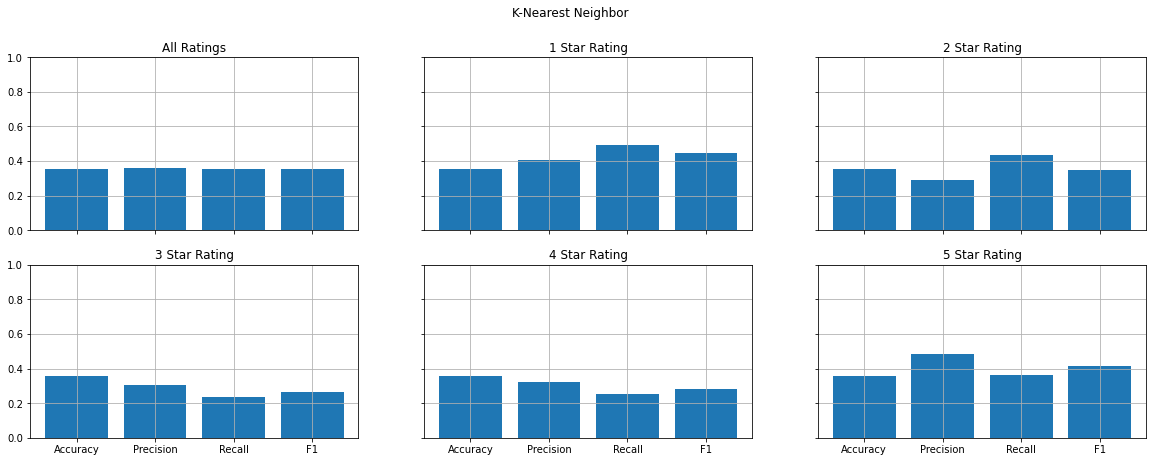

In [28]:
begin = time.time()
prediction = predict(KNeighborsClassifier(n_neighbors=5))
end = time.time()
# prediction = fullPredict(KNeighborsClassifier(), {"n_neighbors": [5, 15, 30, 40], "leaf_size": [10, 20, 30, 35]})
print("K-Nearest Neighbor Results:")
accuracy = analyze(prediction, test, "K-Nearest Neighbor")
knn_metrics = (accuracy, end - begin)

### Multinomial Naive Bayes

MultinomialNB Results:
Confusion Matrix:
[[494 191  55  22  38]
 [186 320 206  55  33]
 [ 81 179 330 146  64]
 [ 34  58 150 348 210]
 [ 34  29  38 169 530]]
Accuracy:  50.55  %
Precision:  50.14687333198059  %
Recall:  50.55  %
F1:  50.30221722566489  %


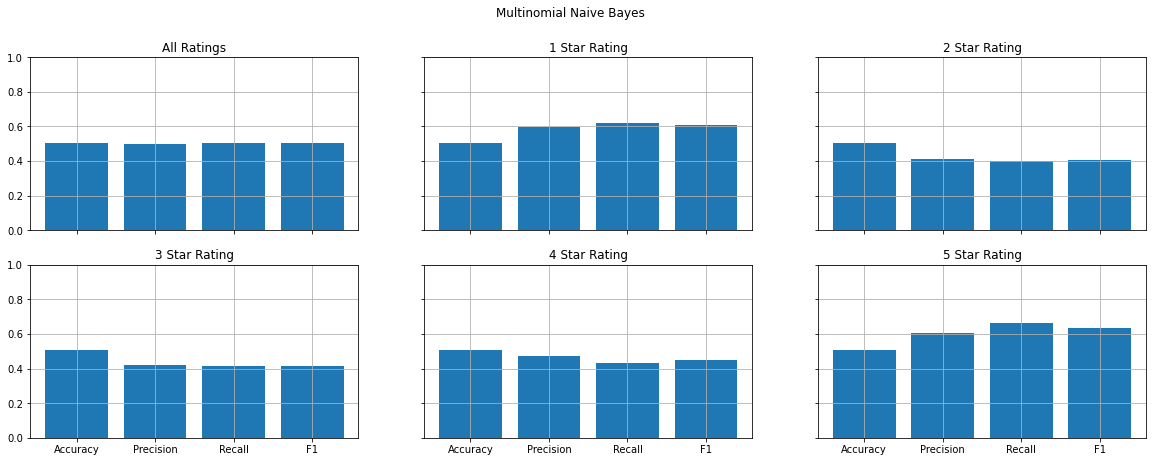

In [27]:
begin = time.time()
prediction = predict(MultinomialNB(), sample_weight=1.0)
end = time.time()
# prediction = fullPredict(MultinomialNB(), {"alpha": [0.0001, 0.5, 1.0]}, sample_weight=1.0)

print("MultinomialNB Results:")
accuracy = analyze(prediction, test, 'Multinomial Naive Bayes')
nb_metrics = (accuracy, end - begin)

### Random Forest

RandomForestClassifier Results:
Confusion Matrix:
[[505 125  63  36  71]
 [247 253 177  66  57]
 [110 177 304 129  80]
 [ 66  61 177 257 239]
 [ 47  35  48 142 528]]
Accuracy:  46.175  %
Precision:  45.02750311012402  %
Recall:  46.175  %
F1:  45.192344109995176  %


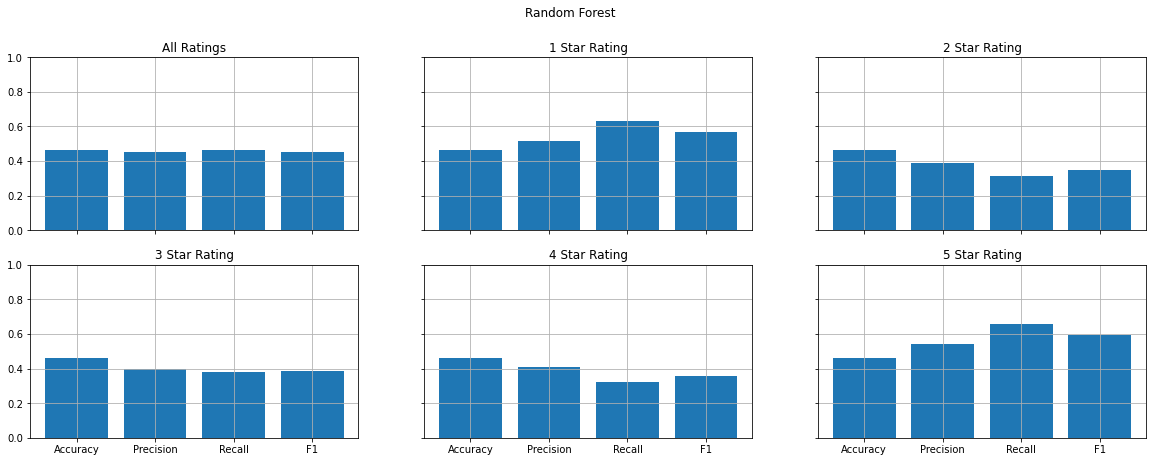

In [29]:
begin = time.time()
prediction = predict(RandomForestClassifier(n_estimators=100), sample_weight=1.0) 
#prediction = fullPredict(RandomForestClassifier(), {"n_estimators": [50, 100]} , sample_weight=1.0)
end = time.time()

print("RandomForestClassifier Results:")
accuracy = analyze(prediction, test, 'Random Forest')
rforest_metrics = (accuracy, end - begin)

### Decision Tree

DecisionTreeClassifier Results:
Confusion Matrix:
[[322 184 136  87  71]
 [200 217 192 100  91]
 [120 159 239 168 114]
 [ 94 116 174 216 200]
 [ 85  82 118 189 326]]
Accuracy:  33.0  %
Precision:  32.948182586013765  %
Recall:  33.0  %
F1:  32.95775200086782  %


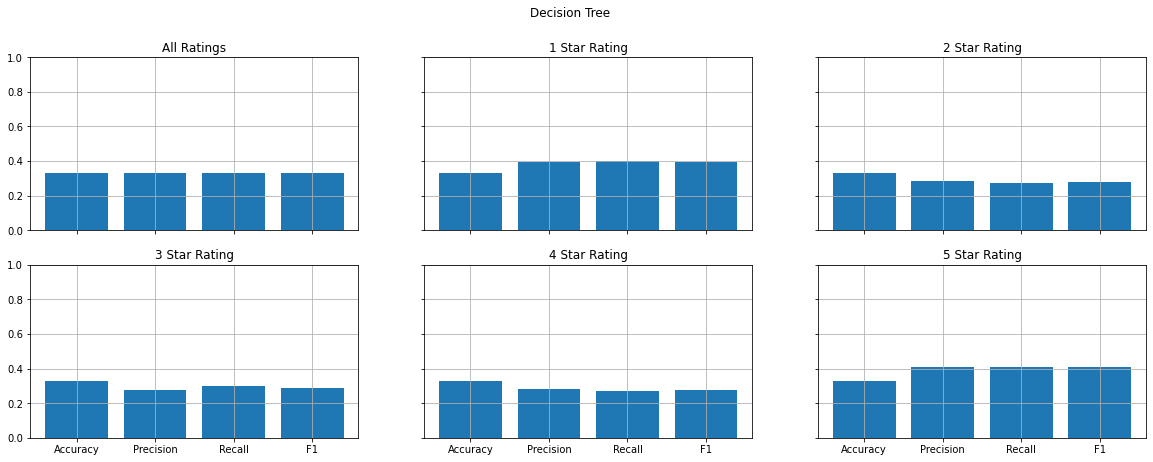

In [30]:
begin = time.time()
prediction = predict(DecisionTreeClassifier(), sample_weight=1.0)
# prediction = fullPredict(DecisionTreeClassifier(), {"criterion": ["gini", "entropy", "log_loss"], "splitter": ["best", "random"]} , sample_weight=1.0)
end = time.time()

print("DecisionTreeClassifier Results:")
accuracy = analyze(prediction, test, 'Decision Tree')
dtree_metrics = (accuracy, end - begin)

### Perceptron

Perceptron Results:
Confusion Matrix:
[[450 227  55  33  35]
 [221 319 150  80  30]
 [ 85 230 250 175  60]
 [ 46  91 146 323 194]
 [ 35  66  51 239 409]]
Accuracy:  43.775  %
Precision:  44.0958200492072  %
Recall:  43.775  %
F1:  43.78283995408955  %


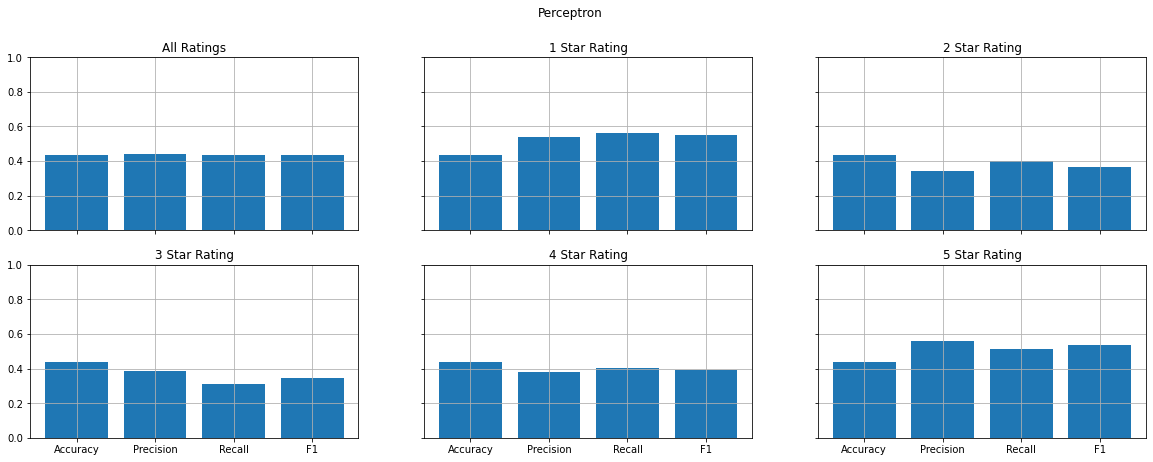

In [31]:
begin = time.time()
prediction = predict(Perceptron(), sample_weight=1.0)
# prediction = fullPredict(Perceptron(), {"alpha": [0.0001, 0.001]} , sample_weight=1.0)
end = time.time()

print("Perceptron Results:")
accuracy = analyze(prediction, test, 'Perceptron')
perceptron_metrics = (accuracy, end - begin)

### Logistic Regression

LogisticRegression Results:
Confusion Matrix:
[[537 156  53  27  27]
 [208 318 190  60  24]
 [ 76 187 338 151  48]
 [ 33  44 158 356 209]
 [ 32  27  34 174 533]]
Accuracy:  52.05  %
Precision:  51.50178930175616  %
Recall:  52.05  %
F1:  51.71183756238891  %


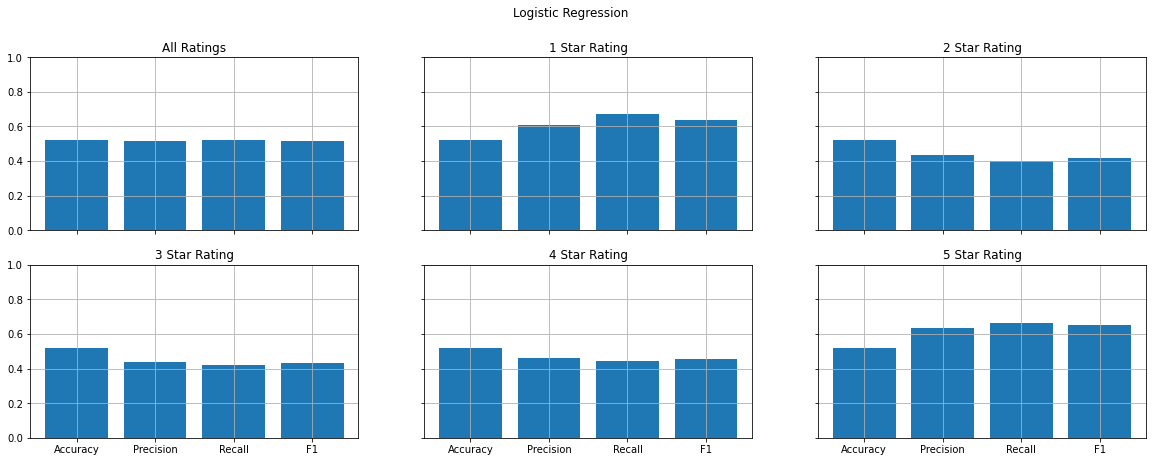

In [35]:
begin = time.time()
prediction = predict(LogisticRegression(class_weight='balanced', solver='saga'), sample_weight=1.0)
# Best grid params: {'class_weight': 'balanced', 'solver': 'saga'} este foi o resultado do grid search
#prediction = fullPredict(LogisticRegression(), {#"penalty": ["l1", "l2", "elastic", "none"],
#    "class_weight": ["balanced", None], "solver": ["newton-cg", "lbfgs", "sag", "saga"]
#}, sample_weight=1.0)
end = time.time()

print("LogisticRegression Results:")
accuracy = analyze(prediction, test, 'Logistic Regression')
logregression_metrics = (accuracy, end - begin)

### Linear SVC

LinearSVC Results:
Confusion Matrix:
[[541 150  50  25  34]
 [230 297 180  61  32]
 [ 79 181 327 150  63]
 [ 40  45 149 340 226]
 [ 35  24  33 169 539]]
Accuracy:  51.1  %
Precision:  50.25501481048139  %
Recall:  51.1  %
F1:  50.50968634488595  %


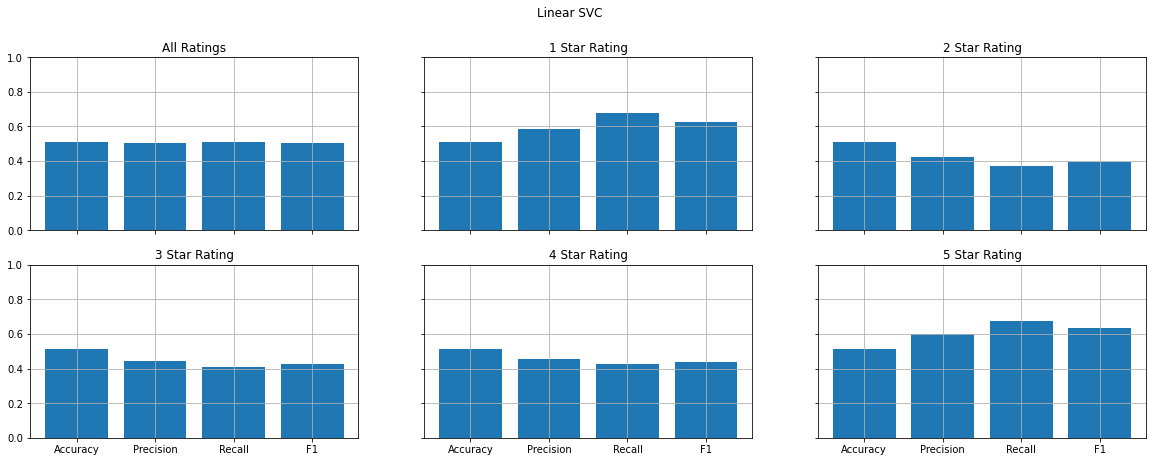

In [42]:
begin = time.time()
prediction = predict(LinearSVC(C= 0.2, class_weight= 'balanced', dual=True, loss='squared_hinge', multi_class='ovr'), sample_weight=1.0)
# Best grid params: {'C': 0.2, 'class_weight': 'balanced', 'dual': True, 'loss': 'squared_hinge', 'multi_class': 'ovr'}
# prediction = fullPredict(LinearSVC(), {
#    "class_weight": ["balanced", None], "loss": ["hinge", "squared_hinge"], "multi_class": ["ovr", "crammer_singer"], "C": [0.2, 0.5, 1.0, 2.0], "dual": [True]
# }, sample_weight=1.0)
end = time.time()

print("LinearSVC Results:")
accuracy = analyze(prediction, test, 'Linear SVC')
linearSVC_metrics = (accuracy, end - begin)

### Neural Network (Multi-Layer Perceptron)

NeuralNetwork Results:
Confusion Matrix:
[[477 186  78  31  28]
 [220 283 199  66  32]
 [ 70 195 304 164  67]
 [ 35  63 176 318 208]
 [ 37  35  59 215 454]]
Accuracy:  45.9  %
Precision:  45.76779513773086  %
Recall:  45.9  %
F1:  45.82161236099417  %


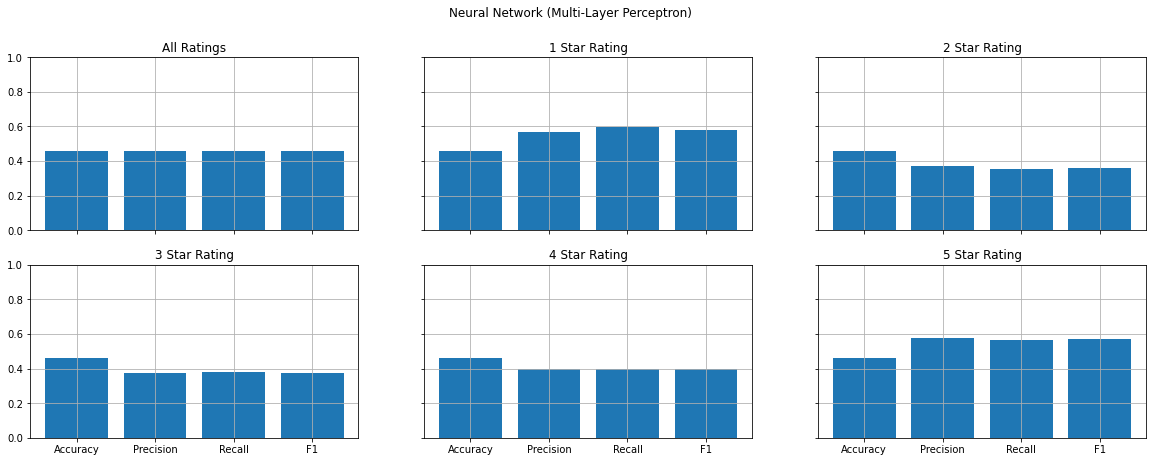

In [43]:
begin = time.time()
prediction = predict(MLPClassifier())
end = time.time()

print("NeuralNetwork Results:")
accuracy = analyze(prediction, test, 'Neural Network (Multi-Layer Perceptron)')
neuralnet_metrics = (accuracy, end - begin)

### Comparing Classifiers

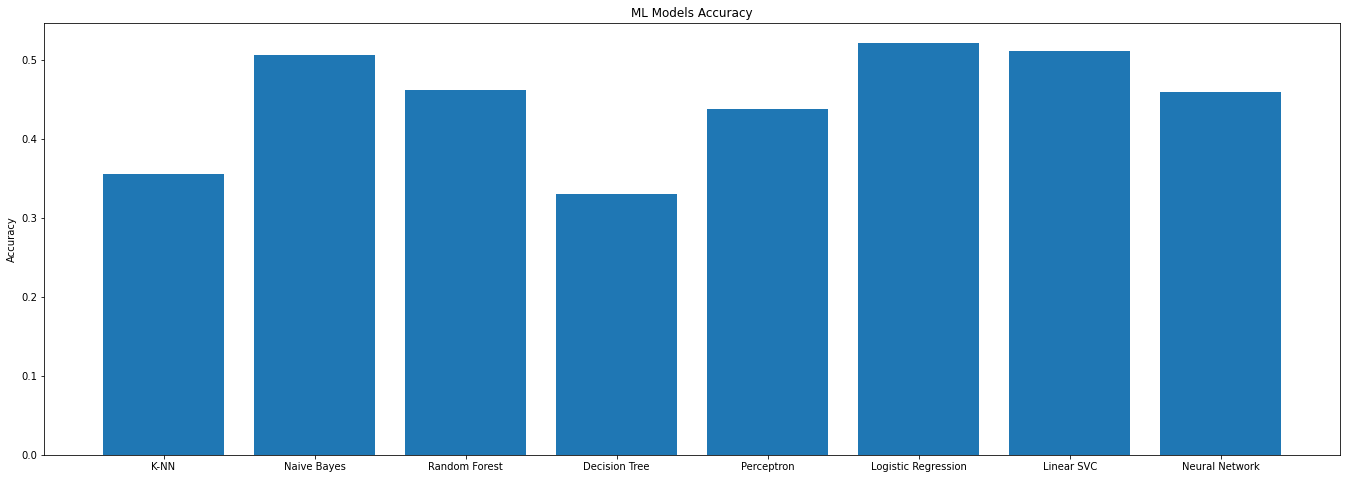

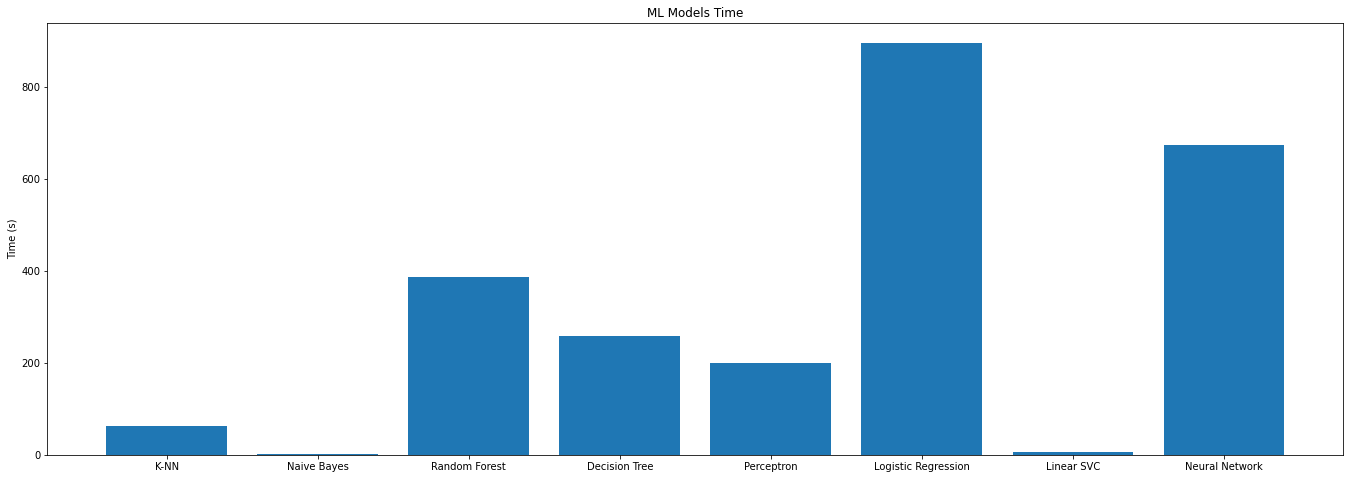

In [44]:
models=['K-NN', 'Naive Bayes', 'Random Forest', 'Decision Tree', 'Perceptron', 'Logistic Regression', 'Linear SVC', 'Neural Network']
accuracies=[knn_metrics[0], nb_metrics[0], rforest_metrics[0], dtree_metrics[0], perceptron_metrics[0], logregression_metrics[0], linearSVC_metrics[0], neuralnet_metrics[0]]
execTimes=[knn_metrics[1], nb_metrics[1], rforest_metrics[1], dtree_metrics[1], perceptron_metrics[1], logregression_metrics[1], linearSVC_metrics[1], neuralnet_metrics[1]]

plot_bar(models, accuracies, 'ML Models Accuracy', 'Accuracy', '')

plot_bar(models, execTimes, 'ML Models Time', 'Time (s)', '')